In [15]:
%pip install requests
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install numpy
import requests
import pandas as pd
from datetime import datetime, timedelta
import os
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip in

In [5]:
API_KEY = "T7FIYGXORKN290S6"  # Replace with your API key
BASE_URL = "https://www.alphavantage.co/query"

In [6]:
class MarketDataFetcher:
    def __init__(self, api_key: str):
        """
        Initialize the MarketDataFetcher with your Alpha Vantage API key.
        Sign up for free at: https://www.alphavantage.co/support/#api-key
        """
        self.api_key = api_key
        self.base_url = "https://www.alphavantage.co/query"
        
    def get_stock_data(self, symbol: str, interval: str = 'daily') -> pd.DataFrame:
        """
        Fetch historical stock data for a given symbol.
        """
        params = {
            'function': f'TIME_SERIES_{interval.upper()}',
            'symbol': symbol,
            'apikey': self.api_key,
            'outputsize': 'compact'
        }
        
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            data = response.json()
            
            time_series_key = f'Time Series ({interval.capitalize()})'
            if time_series_key not in data:
                raise ValueError(f"No data found for symbol {symbol}")
                
            df = pd.DataFrame.from_dict(data[time_series_key], orient='index')
            df.columns = [col.split('. ')[1] for col in df.columns]
            
            for col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                
            return df
            
        except requests.exceptions.RequestException as e:
            raise Exception(f"Error fetching data: {str(e)}")
            
    def get_company_overview(self, symbol: str) -> Dict:
        """
        Fetch company overview data.
        """
        params = {
            'function': 'OVERVIEW',
            'symbol': symbol,
            'apikey': self.api_key
        }
        
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            raise Exception(f"Error fetching company overview: {str(e)}")
            
    def get_latest_price(self, symbol: str) -> float:
        """
        Fetch the latest price for a given symbol.
        """
        params = {
            'function': 'GLOBAL_QUOTE',
            'symbol': symbol,
            'apikey': self.api_key
        }
        
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            data = response.json()
            return float(data['Global Quote']['05. price'])
        except (requests.exceptions.RequestException, KeyError) as e:
            raise Exception(f"Error fetching latest price: {str(e)}")

In [7]:
fetcher = MarketDataFetcher(API_KEY)

In [8]:
symbol = 'AAPL'  # Example using Apple stock
historical_data = fetcher.get_stock_data(symbol)
print("Historical Data Shape:", historical_data.shape)
historical_data.head()

Historical Data Shape: (100, 5)


,open,high,low,close,volume
2024-12-20,248.04,255.00,245.6900,254.49,147495267
2024-12-19,247.50,252.00,247.0949,249.79,60882264
2024-12-18,252.16,254.28,247.7400,248.05,56774101
2024-12-17,250.08,253.83,249.7800,253.48,51356360
2024-12-16,247.99,251.38,247.6500,251.04,51694753


In [9]:
company_info = fetcher.get_company_overview(symbol)
important_metrics = {
    'MarketCapitalization': company_info.get('MarketCapitalization'),
    'PERatio': company_info.get('PERatio'),
    'DividendYield': company_info.get('DividendYield'),
    '52WeekHigh': company_info.get('52WeekHigh'),
    '52WeekLow': company_info.get('52WeekLow')
}
pd.Series(important_metrics)

MarketCapitalization    3846819807000
PERatio                         41.86
DividendYield                  0.0039
52WeekHigh                        255
52WeekLow                      163.49
dtype: object

In [10]:
latest_price = fetcher.get_latest_price(symbol)
print(f"Latest price for {symbol}: ${latest_price}")

Latest price for AAPL: $254.49


Date range in our data:
Start date: 2024-08-01 00:00:00
End date: 2024-12-20 00:00:00


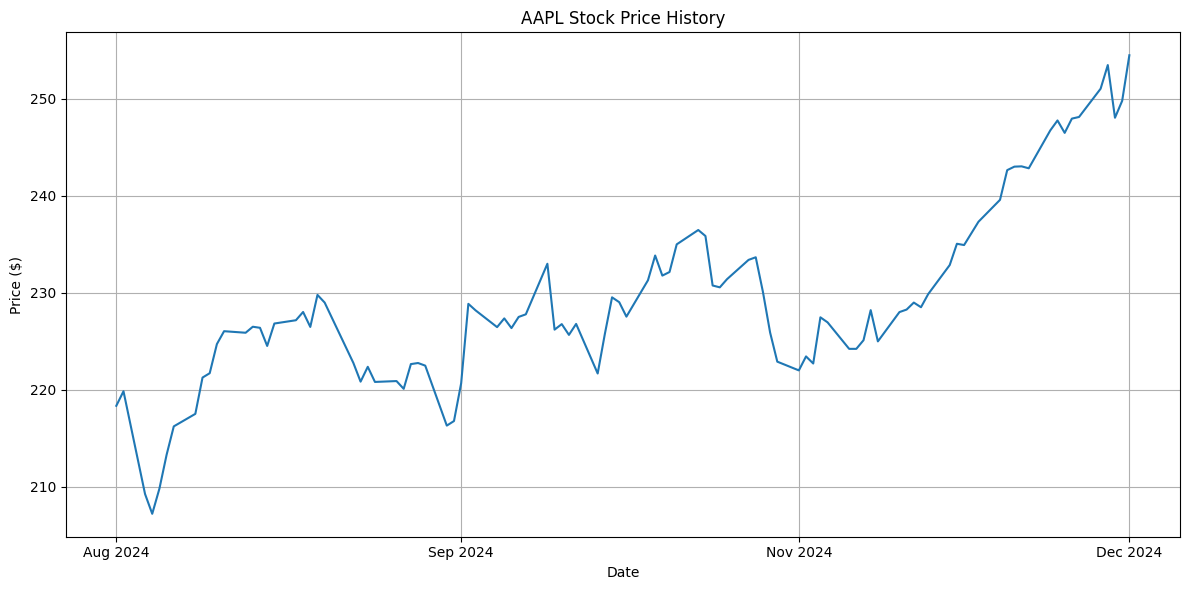

In [16]:
# First, let's check our actual date range
print("Date range in our data:")
print(f"Start date: {historical_data.index[0]}")
print(f"End date: {historical_data.index[-1]}")

# Visualization cell with clear date markers
plt.figure(figsize=(12, 6))
plt.plot(historical_data.index, historical_data['close'])
plt.title(f'{symbol} Stock Price History')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)

# Make sure index is datetime
historical_data.index = pd.to_datetime(historical_data.index)

# Sort index to ensure chronological order
historical_data = historical_data.sort_index()

# Calculate evenly spaced indices for 4 dates
indices = np.linspace(0, len(historical_data)-1, 4, dtype=int)
dates_to_show = historical_data.index[indices]

# Set the xticks and format them
plt.xticks(dates_to_show, [d.strftime('%b %Y') for d in dates_to_show], rotation=0)
plt.margins(x=0.05)

# Ensure no text gets cut off
plt.tight_layout()
plt.show()

In [17]:
def add_technical_indicators(df):
    # 20-day moving average
    df['MA20'] = df['close'].rolling(window=20).mean()
    
    # Relative Strength Index (RSI)
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    return df

technical_data = add_technical_indicators(historical_data.copy())
technical_data.tail()

,open,high,low,close,volume,MA20,RSI
2024-12-16,247.99,251.38,247.6500,251.04,51694753,239.1575,92.473118
2024-12-17,250.08,253.83,249.7800,253.48,51356360,240.4305,92.560074
2024-12-18,252.16,254.28,247.7400,248.05,56774101,241.4190,74.350408
2024-12-19,247.50,252.00,247.0949,249.79,60882264,242.4585,73.706240
2024-12-20,248.04,255.00,245.6900,254.49,147495267,243.7570,75.940111


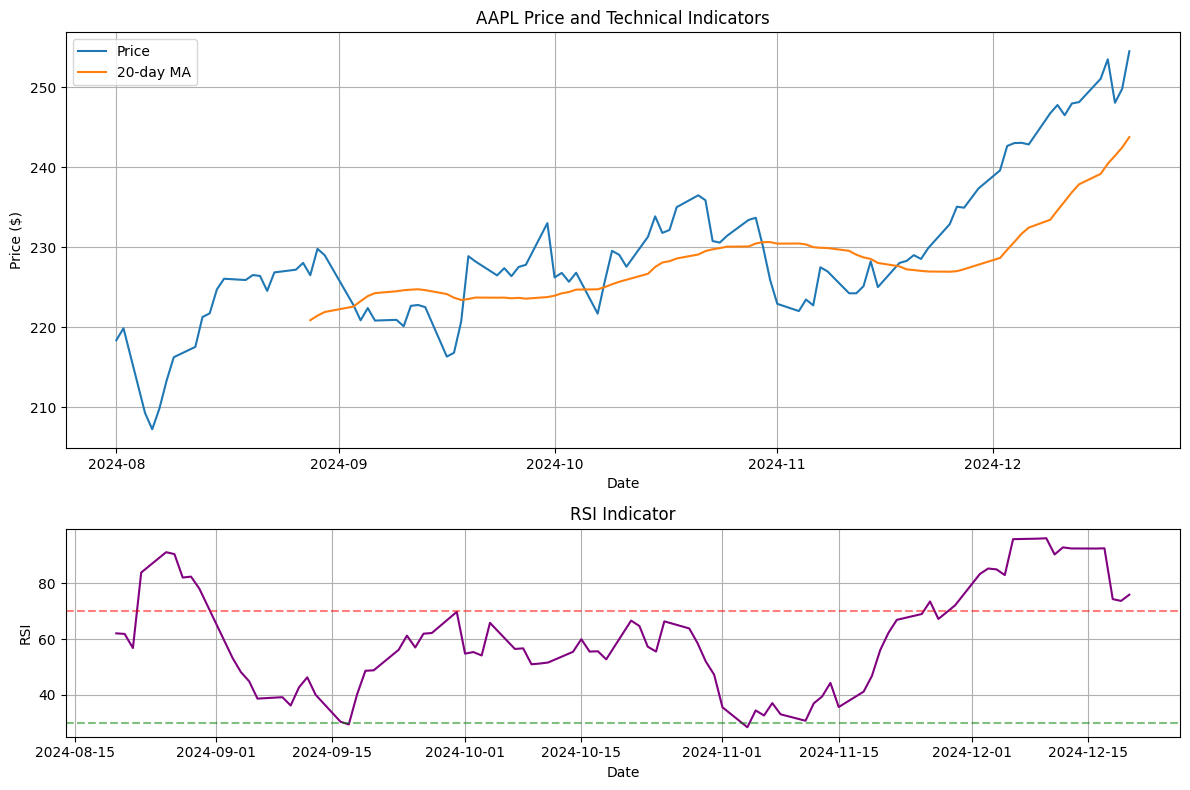

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[2, 1])

# Price and MA plot
ax1.plot(technical_data.index, technical_data['close'], label='Price')
ax1.plot(technical_data.index, technical_data['MA20'], label='20-day MA')
ax1.set_title(f'{symbol} Price and Technical Indicators')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price ($)')
ax1.grid(True)
ax1.legend()

# RSI plot
ax2.plot(technical_data.index, technical_data['RSI'], color='purple')
ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5)
ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5)
ax2.set_title('RSI Indicator')
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [19]:
os.makedirs('market_data', exist_ok=True)

# Save historical data
historical_data.to_csv(f'market_data/{symbol}_historical.csv')

# Save company info
import json
with open(f'market_data/{symbol}_overview.json', 'w') as f:
    json.dump(company_info, f, indent=4)

print("Data saved successfully!")

Data saved successfully!
